In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline
)


In [2]:
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert('RGB')

img_url = 'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png'
mask_url = 'https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda:0


In [3]:
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)


unet\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

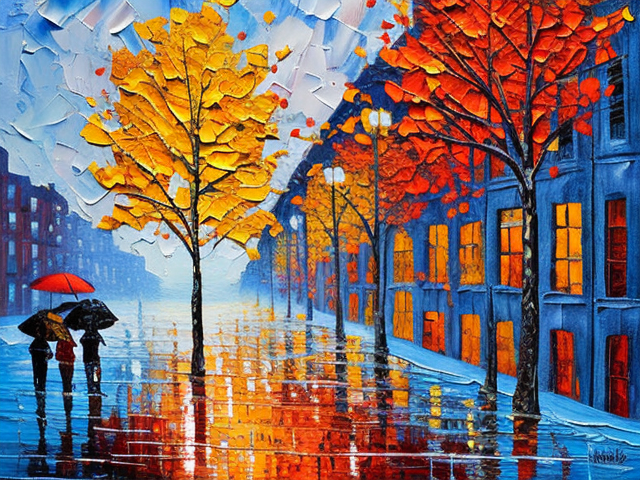

In [4]:
generator = torch.Generator(device=device).manual_seed(0)

pipe_output = pipe(
    prompt = "Palette knife painting of an autumn cityscape",
    negative_prompt = "Oversaturated, blurry, low quality",

    height = 480,
    width = 640,
    guidance_scale = 8,
    num_inference_steps = 35,
    generator=generator
)

pipe_output.images[0]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

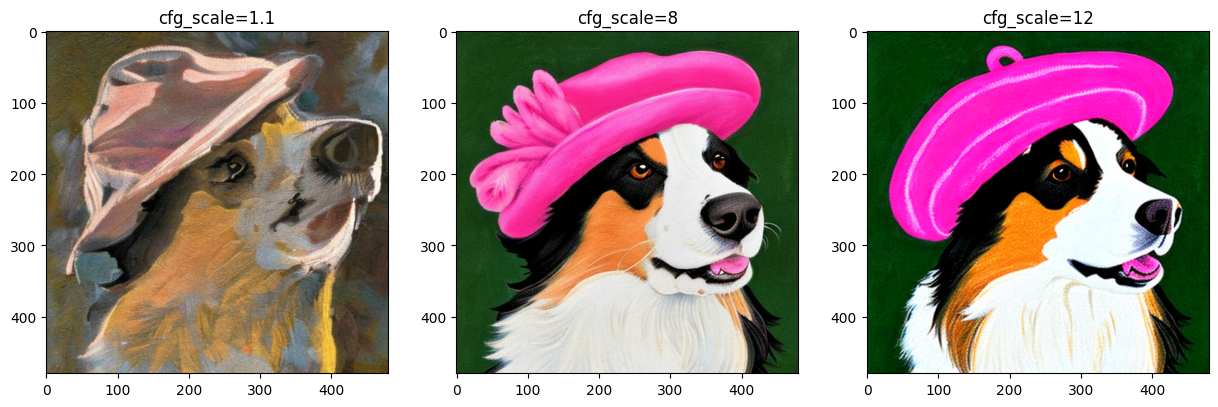

In [5]:
cfg_scales = [1.1, 8, 12]
prompt = "A collie with a pink hat"
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(15, 5))
for i, ax in enumerate(axs):
    im = pipe(prompt=prompt, 
              height=480, width=480, 
              guidance_scale=cfg_scales[i],
              num_inference_steps=35, 
              generator=torch.Generator(device=device).manual_seed(0)
    ).images[0]

    ax.imshow(im)
    ax.set_title(f"cfg_scale={cfg_scales[i]}")


In [6]:
# 查看稳定扩散模型管线所包含的内容
print(list(pipe.components.keys()))
# output: ['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor']


In [7]:
images = torch.rand(1, 3, 512, 512).to(device)*2-1
print("Input images shapes:", images.shape)

with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print('Encoded images shape:', latents.shape)

with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print('Decoded images shape:', decoded_images.shape)

Input images shapes: torch.Size([1, 3, 512, 512])
Encoded images shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [8]:
input_ids = pipe.tokenizer(["A painting of flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embedding = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embedding shape:", text_embedding.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embedding shape: torch.Size([1, 7, 1024])


In [9]:
text_embeddings = pipe.encode_prompt("A painting of flooble", device, 1, False, '')

In [10]:
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print("UNet output shape:", unet_output.shape)

UNet output shape: torch.Size([1, 4, 64, 64])


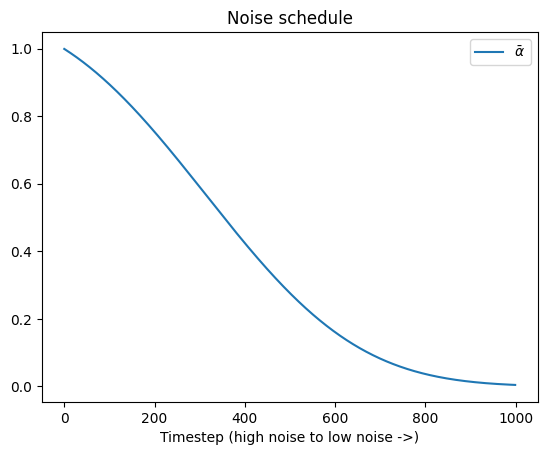

In [11]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)')
plt.title('Noise schedule')
plt.legend()

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.22.0.dev0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

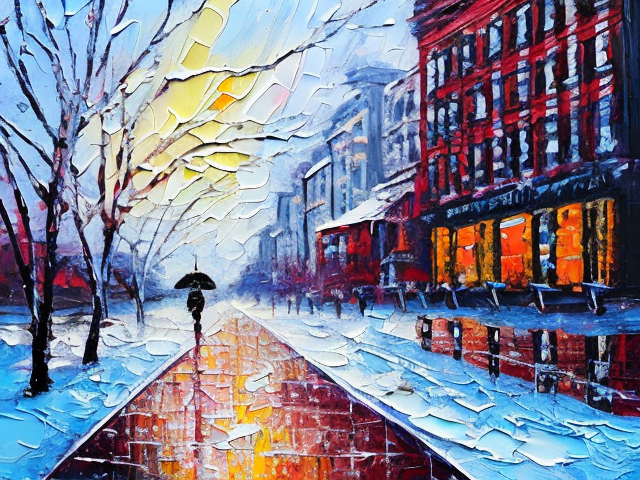

In [12]:
# 尝试不同的调度器
from diffusers import LMSDiscreteScheduler

pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

print('Scheduler config:', pipe.scheduler)

pipe_output = pipe(prompt="Palette knife painting of an winter cityscape",
     height=480, width=640,
     generator=torch.Generator(device=device).manual_seed(0)
)

pipe_output.images[0]

c:\Users\83633\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:241: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
c:\Users\83633\AppData\Local\Programs\Python\Python310\lib\site-packages\diffusers\pipelines\stable_diffusion\pipeline_stable_diffusion.py:457: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


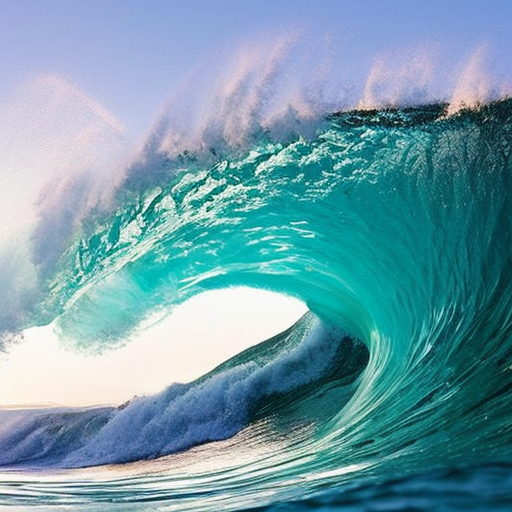

In [13]:
guidance_scale = 8
num_inference_steps = 30
prompt = "Beautiful picture of a wave breaking"
negative_prompt = "zoomed in, blurry, oversaturated, warped"

text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# 源码中的_encode_prompt方法已经被弃用，改用encode_prompt方法
# 但这样会产生错误，如果你解决了这个问题，可以提出你的方法
# prompt_embeds_tuple = pipe.encode_prompt(prompt, device, 1, False, negative_prompt)
# text_embeddings = torch.cat([prompt_embeds_tuple[1], prompt_embeds_tuple[0]])

latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

pipe.scheduler.set_timesteps(num_inference_steps, device=device)

for i, t in enumerate(pipe.scheduler.timesteps):

    latent_model_input = torch.cat([latents]*2)
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # 为了改变条件噪声的权重，我们需要将噪声分为两部分
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale*(noise_pred_text - noise_pred_uncond)

    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())
pipe.numpy_to_pil(image)[0]

In [3]:
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)


vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Output image')

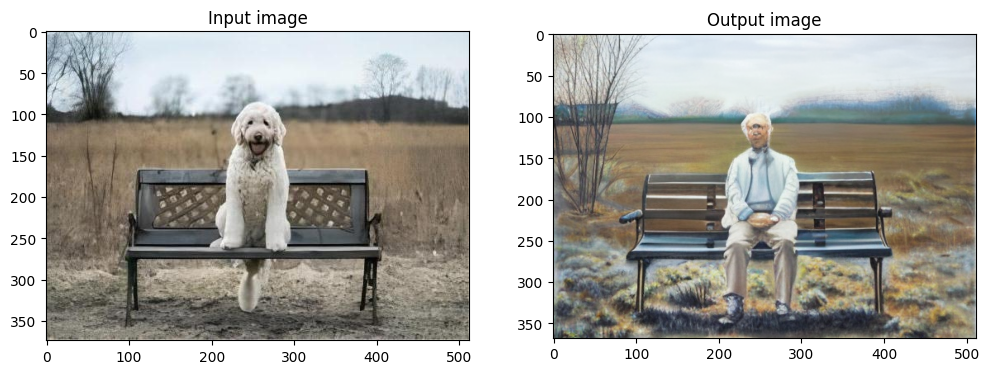

In [25]:
img_path = './dog.jpg'
init_image = Image.open(img_path).convert('RGB')


result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image = init_image,
    strength = 0.6,
).images[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image)
axs[0].set_title("Input image")
axs[1].imshow(result_image)
axs[1].set_title("Output image")

In [ ]:
# inpainting
mask_image = Image.open('./mask.jpg').convert('RGB')

pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting").to(device)
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image); axs[0].set_title("Input image")
axs[1].imshow(mask_image); axs[1].set_title("Mask image")
axs[2].imshow(image); axs[1].set_title("Output image")


In [ ]:
# Depth2Img
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth").to(device)

In [ ]:
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image); axs[0].set_title("Input image")
axs[1].imshow(image); axs[1].set_title("Output image")